In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),
                         std=(0.5, ))
])

In [3]:
train_dataset = torchvision.datasets.MNIST(
    root=".",
    train=True,
    transform=transform,
    download=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 21184417.32it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19443931.59it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24714440.80it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20266519.97it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
len(train_dataset)

60000

In [5]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [6]:
# Discriminator
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1)
)

In [7]:
# Generator
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
D = D.to(device)
G = G.to(device)

In [10]:
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [11]:
# scale img back to (0, 1)
def scale_img(img):
  return (img + 1) / 2

In [12]:
if not os.path.exists("gan_images"):
  os.makedirs("gan_images")

In [13]:
# Training

# Labels to use
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

# save losses
d_losses = []
g_losses = []

num_epochs = 200
for epoch in range(num_epochs):
  for inputs, _ in data_loader:

    # reshape and move to gpu
    n = inputs.size(0)
    inputs = inputs.reshape(n, 784).to(device)

    # set ones and zeros to correct size
    ones = ones_[:n]
    zeros = zeros_[:n]

    # Train Discriminator

    # real images
    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)

    # fake images
    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)

    # GD step
    d_loss = (d_loss_fake + d_loss_real) / 2
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # Train Generator

    for _ in range(2):
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images)
      # reverse the labels
      g_loss = criterion(fake_outputs, ones)
      # GD step
      d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

  print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

  # save a batch of images to file
  fake_images = fake_images.reshape(-1, 1, 28, 28)
  save_image(scale_img(fake_images), f"gan_images/{epoch+1}.png")

Epoch: 0, d_loss: 0.6895486116409302, g_loss: 0.7117824554443359
Epoch: 1, d_loss: 0.6922458410263062, g_loss: 0.6806886196136475
Epoch: 2, d_loss: 0.7251896858215332, g_loss: 0.4554629921913147
Epoch: 3, d_loss: 0.6730670928955078, g_loss: 0.8117930293083191
Epoch: 4, d_loss: 0.6890421509742737, g_loss: 0.6915501952171326
Epoch: 5, d_loss: 0.7008445858955383, g_loss: 0.6959551572799683
Epoch: 6, d_loss: 0.6807750463485718, g_loss: 0.7511358261108398
Epoch: 7, d_loss: 0.6923811435699463, g_loss: 0.685762882232666
Epoch: 8, d_loss: 0.6947633028030396, g_loss: 0.7928850054740906
Epoch: 9, d_loss: 0.6742305755615234, g_loss: 0.7593445777893066
Epoch: 10, d_loss: 0.6759029030799866, g_loss: 0.7565425634384155
Epoch: 11, d_loss: 0.6827271580696106, g_loss: 0.7742472887039185
Epoch: 12, d_loss: 0.6744883060455322, g_loss: 0.713842511177063
Epoch: 13, d_loss: 0.7036525011062622, g_loss: 0.7381323575973511
Epoch: 14, d_loss: 0.6862682104110718, g_loss: 0.720977783203125
Epoch: 15, d_loss: 0.69

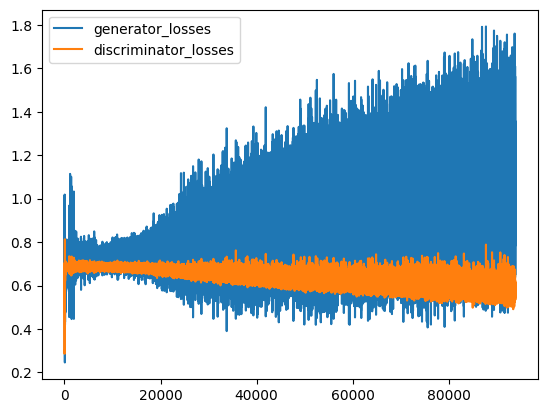

In [14]:
plt.plot(g_losses, label="generator_losses")
plt.plot(d_losses, label="discriminator_losses")
plt.legend();

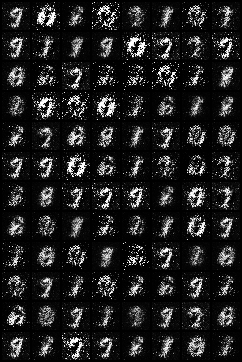

In [16]:
import cv2
from google.colab.patches import cv2_imshow
a = cv2.imread("gan_images/1.png")
cv2_imshow(a)

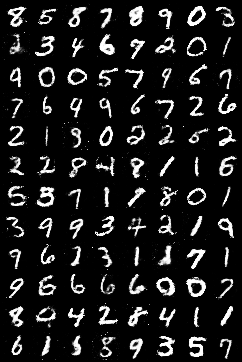

In [17]:
a = cv2.imread("gan_images/50.png")
cv2_imshow(a)

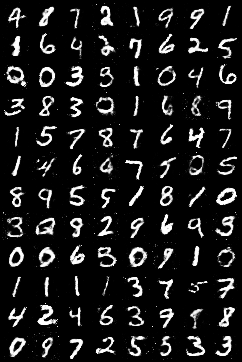

In [18]:
a = cv2.imread("gan_images/100.png")
cv2_imshow(a)

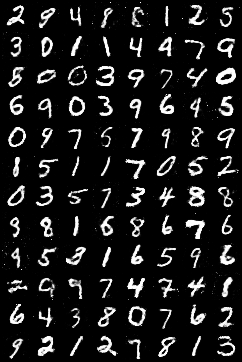

In [19]:
a = cv2.imread("gan_images/150.png")
cv2_imshow(a)

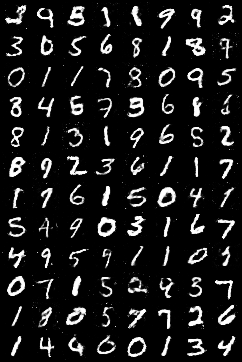

In [20]:
a = cv2.imread("gan_images/200.png")
cv2_imshow(a)